# Модель линейной регрессии

In [268]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Latex

In [269]:
data = pd.read_csv("extended_data.csv", index_col=0, sep=';')

In [270]:
missing = (data.isna().sum() / len(data)) * 100
missing = missing[missing >= 0].sort_values(ascending=False)
missing = pd.DataFrame({'Процент пропущенных значений' : missing})
missing

,Процент пропущенных значений
flags,98.383126
VIN,89.260763
configuration,55.572560
body,51.666778
is_sport_line,42.597645
owner_count,27.154169
owners,27.154169
engine_liters_match_with_passport,26.395635
color_matches_with_passport,26.395635
year_matches_with_passport,26.395635


## Независимые переменные
#### Метрические и дихотомические
    - year
    - mileage
    - petrol_type
    - law
    - is_sport_line
    - engine_volume_lites
    - power_in_hp
    - is_crossover
    - owner_count
#### Категориальные
    - manufacturer
    - color
    - transmission

### Дамми-переменные

In [271]:
manufacturer_dummies = pd.get_dummies(data.manufacturer, prefix='manufacturer', prefix_sep='_', dtype=int)

color_groups = ['black', 'white', 'grey_silver', 'blue_brown', 'red', 'other']
def color_group(x):
    if pd.isna(x):
        return np.nan
    for i in color_groups:
        if x in i:
            return i
    return 'other'

data['color_group'] = data['color'].apply(color_group)
color_dummies = pd.get_dummies(data.color_group, prefix='color_gr_', prefix_sep='_', dtype=int)


data['is_manual_transmission'] = data['transmission'].apply(lambda x : 1 if x == 'manual' else 0)

data['is_diesel'] = data['petrol_type'].apply(lambda x : 1 if x == 'дизель' else 0)
data['law_int'] = data['law'].apply(lambda x : 1 if x else 0)
data['sport_int'] = data['is_sport_line'].apply(lambda x : 1 if x else 0)
data['crossover_int'] = data['is_crossover'].apply(lambda x : 1 if x else 0)


data = pd.concat([data, manufacturer_dummies, color_dummies], axis=1)

## Зависимой переменной принимаем price

In [272]:
data['price'].describe()

count    1.502900e+04
mean     5.445201e+06
std      5.926867e+06
min      3.000000e+04
25%      1.800000e+06
50%      3.390000e+06
75%      6.700000e+06
max      1.000000e+08
Name: price, dtype: float64

In [273]:
data['price'].median()

3390000.0

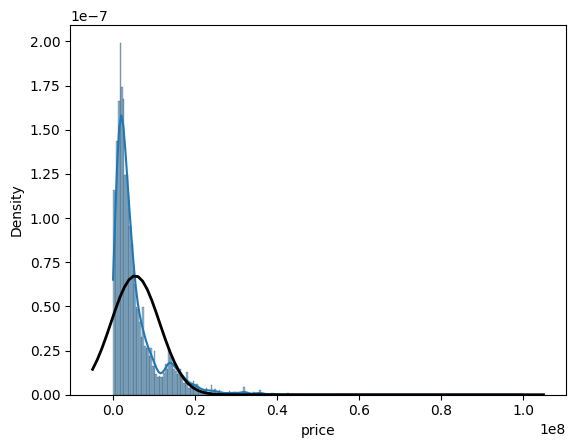

In [274]:
sns.histplot(data.price, kde=True, stat='density')
mu, std = stats.norm.fit(data.price)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [275]:
display(Latex('Skewness: {:.4f}'.format(data['price'].skew())))
display(Latex('Kurtosis: {:.4f}'.format(data['price'].kurt())))
display(Latex('Quartile Deviation: {:.4f}'.format((data['price'].quantile(0.75) - data['price'].quantile(0.25))/2)))
display(Latex('Decile Ratio: {:.4f}'.format(data['price'].quantile(0.9)/data['price'].quantile(0.1))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [276]:
stats.kstest(data.price, 'norm', args=(data.price.mean(), data.price.std()))

KstestResult(statistic=0.19345586058844538, pvalue=0.0, statistic_location=5000000, statistic_sign=1)

Зависимая переменная "price" имеет распределение отличное от нормального (pvalue < 0.05). Также оно асимметрично (сдвиг в сторону меньших значений) и характеризуется пиковостью. Среднее значение - 5 445 201 рублей, стандартное отклонение довольно высокое - 5 926 867 рублей. Медиана  - 3 390 000. Межквартильная широта - 2 450 000 рублей, что также характеризует довольно большой разброс серединных 50% значений относительно медианы. Децильное отношение - 15,9.

## Рассмотрим только изменяющиеся показатели

In [277]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15029 entries, 0 to 15028
Data columns (total 60 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   manufacturer                       15029 non-null  object 
 1   model                              15029 non-null  object 
 2   year                               15029 non-null  int64  
 3   price                              15029 non-null  int64  
 4   URL                                15029 non-null  object 
 5   vehicle_passport                   11110 non-null  object 
 6   owners                             10948 non-null  object 
 7   wanted                             11104 non-null  object 
 8   limitations                        11104 non-null  object 
 9   city                               15029 non-null  object 
 10  engine                             15019 non-null  object 
 11  power                              14819 non-null  object 


In [278]:
import statsmodels.api as sm

y = data_cleaned['price']
x_mult = data_cleaned[independent_vars]
x_mult_constant = sm.add_constant(x_mult)

In [279]:
independent_vars =[ 'mileage', 'law_int', 'owner_count', 'year', 'is_new']

shape_0_prev = data.shape[0]

data_cleaned = data.dropna(subset=[
'year',
'mileage',
'law',
'owner_count',
])

data_cleaned = data_cleaned.copy()
data_cleaned['is_new'] = data['mileage'].apply(lambda x: 1 if x == 0 else 0)

print(shape_0_prev - data_cleaned.shape[0], ' автомобилей исключено из ', shape_0_prev)

y = data_cleaned['price']
x_mult = data_cleaned[independent_vars]
x_mult_constant = sm.add_constant(x_mult)

model2 = sm.OLS(y, x_mult_constant).fit()
print(model2.summary())

print('R^2 = {:f}'.format(model2.rsquared))
print('F-test significance = {:f}'.format(model2.f_pvalue))
print(f'Статистически значимые параметры модели: {model2.pvalues[model2.pvalues < 0.05].index.values}')
print(f'Статистически не значимые параметры модели: {model2.pvalues[model2.pvalues > 0.05].index.values}')
l = []
for (param, index) in zip(model2.params[1:], model2.params.index[1:]):
    l.append('{:.2f} * {}'.format(param, index))

print('Y = {:2f} +\n{}'.format(model2.params.iloc[0], ' + \n'.join(l)))

4172  автомобилей исключено из  15029
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     1879.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        23:39:55   Log-Likelihood:            -1.7624e+05
No. Observations:               10857   AIC:                         3.525e+05
Df Residuals:                   10851   BIC:                         3.525e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       

1. $R^2$ = 0.463996 (46%), что означает, что 46% дисперсии зависимой переменной (цены) объясняется
независимыми переменными, использованными в модели.
2. Значение F-теста (F-test significance) равно 0.000000, что может указывать на то, что модель в целом
значима.
3. Коэффициенты при различных переменных указывают на их влияние на цену автомобиля:
- Mileage (Пробег): Коэффициент -9.49. Это означает, что с увеличением пробега автомобиля на 1
километр, его цена снижается на 9.49 единиц.
- Law Int (Проблемы с законом): Коэффициент -1032612.66. Если у автомобиля проблемы с законом, его цена
снижается на 1032612.66 единиц.
- Owner Count (Количество владельцев): Коэффициент -53450.11. С увеличением количества
владельцев на 1, цена автомобиля снижается на 53450.11 единиц.
- Year (Год выпуска): Коэффициент 152932.73. С увеличением года выпуска на 1, цена автомобиля
повышается на 152932.73 единицы.
- Is New (Новый автомобиль): Коэффициент 8809467.64. Новизна автомобиля увеличивают его цену на 8809467.64 единиц.

## Добавим данные о двигателе, кузове, топливе

In [280]:
independent_vars =[ 'mileage', 'is_diesel', 'sport_int', 'engine_volume_liters',
     'power_in_hp', 'crossover_int', 'owner_count', 'year']

shape_0_prev = data.shape[0]

data_cleaned = data.dropna(subset=[
'year',
'mileage',
'petrol_type',
'is_sport_line',
'engine_volume_liters',
'power_in_hp',
'is_crossover',
'owner_count',
])

print(shape_0_prev - data_cleaned.shape[0], ' автомобилей исключено из ', shape_0_prev)



y = data_cleaned['price']
x_mult = data_cleaned[independent_vars]
x_mult_constant = sm.add_constant(x_mult)

model2 = sm.OLS(y, x_mult_constant).fit()
print(model2.summary())

print('R^2 = {:f}'.format(model2.rsquared))
print('F-test significance = {:f}'.format(model2.f_pvalue))
print(f'Статистически значимые параметры модели: {model2.pvalues[model2.pvalues < 0.05].index.values}')
print(f'Статистически не значимые параметры модели: {model2.pvalues[model2.pvalues > 0.05].index.values}')
l = []
for (param, index) in zip(model2.params[1:], model2.params.index[1:]):
    l.append('{:.2f} * {}'.format(param, index))

print('Y = {:2f} +\n{}'.format(model2.params.iloc[0], ' + \n'.join(l)))

9081  автомобилей исключено из  15029
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     1210.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        23:39:55   Log-Likelihood:                -95541.
No. Observations:                5948   AIC:                         1.911e+05
Df Residuals:                    5940   BIC:                         1.912e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

1. $R^2$ = 0.587853, что означает, что 58.8% дисперсии зависимой переменной (Y) объясняется независимыми переменными, использованными в модели.

2. Значение F-теста (F-test significance) равно 0.000000, что может указывать на то, что модель в целом значима.

3. Коэффициенты при различных переменных указывают на их влияние на цену автомобиля:

- Mileage (Пробег): Коэффициент -6.95. Это означает, что с увеличением пробега автомобиля на 1 километр, его цена снижается на 6.95 единиц.
- Is Diesel (Дизельный двигатель): Коэффициент 0.00. Поскольку коэффициент равен нулю, тип двигателя (дизельный или бензиновый) не оказывает статистически значимого влияния на цену автомобиля.
- Sport Int (Спортивный класс): Коэффициент 932976.45. Принадлежность авто к спортивному классу связана с увеличением цены автомобиля на 932976.45 единиц.
- Engine Volume Liters (Объем двигателя в литрах): Коэффициент -610097.95. С увеличением объема двигателя на 1 литр, цена автомобиля снижается на 610097.95 единиц.
- Power in HP (Мощность в лошадиных силах): Коэффициент 19253.33. При увеличении мощности на 1 лошадиную силу, цена автомобиля повышается на 19253.33 единицы.
- Crossover Int (Кроссовер): Коэффициент 792425.99. Принадлежность авто к кроссоверному типу связана с увеличением его цены на 792425.99 единиц.
- Owner Count (Количество владельцев): Коэффициент -148904.80. С увеличением количества владельцев на 1, цена автомобиля снижается на 148904.80 единиц.
- Year (Год выпуска): Коэффициент 63328.79. С увеличением года выпуска на 1, цена автомобиля повышается на 63328.79 единиц.

## Добавим информацию о КПП

In [281]:
independent_vars =[ 'mileage', 'is_diesel', 'law_int', 'sport_int', 'engine_volume_liters',
     'power_in_hp', 'crossover_int', 'owner_count', 
      'is_manual_transmission', 'year']

shape_0_prev = data.shape[0]

data_cleaned = data.dropna(subset=[
'year',
'mileage',
'petrol_type',
'law',
'is_sport_line',
'engine_volume_liters',
'power_in_hp',
'is_crossover',
'owner_count',
'transmission'
])

print(shape_0_prev - data_cleaned.shape[0], ' автомобилей исключено из ', shape_0_prev)



y = data_cleaned['price']
x_mult = data_cleaned[independent_vars]
x_mult_constant = sm.add_constant(x_mult)

model2 = sm.OLS(y, x_mult_constant).fit()
print(model2.summary())

print('R^2 = {:f}'.format(model2.rsquared))
print('F-test significance = {:f}'.format(model2.f_pvalue))
print(f'Статистически значимые параметры модели: {model2.pvalues[model2.pvalues < 0.05].index.values}')
print(f'Статистически не значимые параметры модели: {model2.pvalues[model2.pvalues > 0.05].index.values}')
l = []
for (param, index) in zip(model2.params[1:], model2.params.index[1:]):
    l.append('{:.2f} * {}'.format(param, index))

print('Y = {:2f} +\n{}'.format(model2.params.iloc[0], ' + \n'.join(l)))

9081  автомобилей исключено из  15029
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1097.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        23:39:55   Log-Likelihood:                -95265.
No. Observations:                5948   AIC:                         1.906e+05
Df Residuals:                    5938   BIC:                         1.906e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

1. $R^2$ = 0.624347, что означает, что 62.4% дисперсии зависимой переменной (Y) объясняется независимыми переменными, использованными в модели.

2. Значение F-теста (F-test significance) равно 0.000000, что может указывать на то, что модель в целом значима.

3. Коэффициенты при различных переменных указывают на их влияние на цену автомобиля:

- Mileage (Пробег): Коэффициент -5.96. Это означает, что с увеличением пробега автомобиля на 1 километр, его цена снижается на 5.96 единиц.
- Is Diesel (Дизельный двигатель): Коэффициент 0.00. Поскольку коэффициент равен нулю, тип двигателя (дизельный или бензиновый) не оказывает статистически значимого влияния на цену автомобиля.
- Law Int (Проблемы с законом): Коэффициент -678205.65. Если автомобиль имеет проблемы с законом, его цена снижается на 678205.65 единиц.
- Sport Int (Спортивный класс): Коэффициент 703391.38. Принадлежность автомобиля к кроссоверному классу связано с увеличением цены автомобиля на 703391.38 единиц.
- Engine Volume Liters (Объем двигателя в литрах): Коэффициент -276401.57. С увеличением объема двигателя на 1 литр, цена автомобиля снижается на 276401.57 единиц.
- Power in HP (Мощность в лошадиных силах): Коэффициент 17577.72. При увеличении мощности на 1 лошадиную силу, цена автомобиля повышается на 17577.72 единиц.
- Crossover Int (Кроссовер): Коэффициент 791179.40. Принадлежность автомобиля к кроссоверному типу связано с увеличением его цены на 791179.40 единиц.
- Owner Count (Количество владельцев): Коэффициент -104861.18. С увеличением количества владельцев на 1, цена автомобиля снижается на 104861.18 единиц.
- Is Manual Transmission (Механическая коробка передач): Коэффициент 3103190.13. Наличие механической коробки передач связано с увеличением цены на 3103190.13 единиц.
- Year (Год выпуска): Коэффициент 166770.66. С увеличением года выпуска на 1, цена автомобиля повышается на 166770.66 единиц.

## Добавим информацию о производителе

In [282]:
independent_vars =[ 'mileage', 'is_diesel', 'law_int', 'sport_int', 'engine_volume_liters',
     'power_in_hp', 'crossover_int', 'owner_count', 
     'manufacturer_BMW', 'manufacturer_Mercedes-Benz', 'is_manual_transmission', 'year']

shape_0_prev = data.shape[0]

data_cleaned = data.dropna(subset=[
'year',
'mileage',
'petrol_type',
'law',
'is_sport_line',
'engine_volume_liters',
'power_in_hp',
'is_crossover',
'owner_count',
'manufacturer',
'transmission'
])

print(shape_0_prev - data_cleaned.shape[0], ' автомобилей исключено из ', shape_0_prev)



y = data_cleaned['price']
x_mult = data_cleaned[independent_vars]
x_mult_constant = sm.add_constant(x_mult)

model2 = sm.OLS(y, x_mult_constant).fit()
print(model2.summary())

print('R^2 = {:f}'.format(model2.rsquared))
print('F-test significance = {:f}'.format(model2.f_pvalue))
print(f'Статистически значимые параметры модели: {model2.pvalues[model2.pvalues < 0.05].index.values}')
print(f'Статистически не значимые параметры модели: {model2.pvalues[model2.pvalues > 0.05].index.values}')
l = []
for (param, index) in zip(model2.params[1:], model2.params.index[1:]):
    l.append('{:.2f} * {}'.format(param, index))

print('Y = {:2f} +\n{}'.format(model2.params.iloc[0], ' + \n'.join(l)))

9081  автомобилей исключено из  15029
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     942.6
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        23:39:55   Log-Likelihood:                -95172.
No. Observations:                5948   AIC:                         1.904e+05
Df Residuals:                    5936   BIC:                         1.904e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

1. $R^2$ = 0.635935 (63,5%), что означает, что 63,5% дисперсии зависимой переменной (цены)
объясняется независимыми переменными, использованными в модели.
2. Значение F-теста (F-test significance) равно 0.000000, что может указывать на то, что модель в целом
значима.
3. Коэффициенты при различных переменных указывают на их влияние на цену автомобиля:
- Mileage (Пробег): Коэффициент -5.94. Это означает, что с увеличением пробега автомобиля на 1
километр, его цена снижается на 5.94 рубля.
- Is Diesel (Дизельный двигатель): Коэффициент 0.00. Поскольку коэффициент равен нулю, тип
двигателя (дизельный или бензиновый) не оказывает статистически значимого влияния на цену
автомобиля.
- Law Int (Проблемы с законом): Коэффициент -596479.13. Если автомобиль имеет проблемы с законом, его стоимость
снижается на 596479.13 рублей.
- Sport Int (Спортивная линейка): Коэффициент 604690.41. Принадлежность автомобиля к спортивной линейке делает автомобиль дороже на 600 тысяч рублей.
- Engine Volume Liters (Объем двигателя в литрах): Коэффициент -439099.39. С увеличением объема
двигателя на 1 литр, цена автомобиля снижается на -439099.39 рублей.
- Power in HP (Мощность в лошадиных силах): Коэффициент 18230.77. При увеличении мощности на 1
лошадиную силу, цена автомобиля повышается на 18230.77 единиц.
- Crossover Int (Кроссовер): Коэффициент 741719.41. Принадлежность автомобиля к кроссоверному
типу связано с увеличением его цены на 741719.41 рублей.
- Owner Count (Количество владельцев): Коэффициент -112366.39. С увеличением количества
владельцев на 1, цена автомобиля снижается на -112366.39 рублей.
- Manufacturer (Производитель): Для производителей (BMW: 646024.08, Mercedes-Benz: 938110.94) указаны соответствующие коэффициенты, по сравнению с референтной группой (Audi).
- Is Manual Transmission (Механическая коробка передач): Коэффициент 3146945.09. Наличие
механической коробки передач связано с увеличением цены на 3146945.09 единицы.
- Year (Год выпуска): Коэффициент 160614.15. С увеличением года выпуска на 1, цена автомобиля
повышается на 160614.15 единицы.


## Добавим цвет

In [297]:
independent_vars =[ 'mileage', 'is_diesel', 'law_int', 'sport_int', 'engine_volume_liters',
     'power_in_hp', 'crossover_int', 'owner_count', 
     'manufacturer_BMW', 'manufacturer_Mercedes-Benz',
     'color_gr__blue_brown', 'color_gr__grey_silver',
     'color_gr__other', 'color_gr__red', 'color_gr__white', 'is_manual_transmission', 'year']

shape_0_prev = data.shape[0]

data_cleaned = data.dropna(subset=[
'year',
'mileage',
'petrol_type',
'law',
'is_sport_line',
'engine_volume_liters',
'power_in_hp',
'is_crossover',
'owner_count',
'manufacturer',
'color',
'transmission'
])
     
print(shape_0_prev - data_cleaned.shape[0], ' автомобилей исключено из ', shape_0_prev)

y = data_cleaned['price']
x_mult = data_cleaned[independent_vars]
x_mult_constant = sm.add_constant(x_mult)

model2 = sm.OLS(y, x_mult_constant).fit()
print(model2.summary())

print('R^2 = {:f}'.format(model2.rsquared))
print('F-test significance = {:f}'.format(model2.f_pvalue))
print(f'Статистически значимые параметры модели: {model2.pvalues[model2.pvalues < 0.05].index.values}')
print(f'Статистически не значимые параметры модели: {model2.pvalues[model2.pvalues > 0.05].index.values}')
l = []
for (param, index) in zip(model2.params[1:], model2.params.index[1:]):
    l.append('{:.2f} * {}'.format(param, index))

print('Y = {:2f} +\n{}'.format(model2.params.iloc[0], ' + \n'.join(l)))

9128  автомобилей исключено из  15029
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     646.7
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        23:45:38   Log-Likelihood:                -94406.
No. Observations:                5901   AIC:                         1.888e+05
Df Residuals:                    5884   BIC:                         1.890e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [298]:
display(Latex('$R^2$ = {:f}'.format(model2.rsquared)))
display(Latex('F-test significance = {:f}'.format(model2.f_pvalue)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Модель статистически значима. Объясняет 63% вариации значений зависимой переменной.

In [299]:
display(Latex('Статистически значимые параметры модели:'))
for param in model2.pvalues[model2.pvalues < 0.05].index.values:
    display(Latex(param))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [300]:
display(Latex('Статистически незначимые параметры модели:'))
for param in model2.pvalues[model2.pvalues >= 0.05].index.values:
    display(Latex(param))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [301]:
l = []
for (param, index) in zip(model2.params[1:], model2.params.index[1:]):
    l.append('{:.2f} * {}'.format(param, index))

print('Y = {:2f} +\n{}'.format(model2.params.iloc[0], ' + \n'.join(l)))

Y = -320733165.509562 +
-6.12 * mileage + 
-0.00 * is_diesel + 
-646168.62 * law_int + 
615317.96 * sport_int + 
-475166.22 * engine_volume_liters + 
18176.69 * power_in_hp + 
763042.96 * crossover_int + 
-114052.63 * owner_count + 
640163.55 * manufacturer_BMW + 
937564.17 * manufacturer_Mercedes-Benz + 
-329726.28 * color_gr__blue_brown + 
-32548.47 * color_gr__grey_silver + 
-36273.16 * color_gr__other + 
-350333.29 * color_gr__red + 
-394017.11 * color_gr__white + 
3161779.23 * is_manual_transmission + 
160136.06 * year


- Пробег (Mileage): Коэффициент -6.12. Это означает, что с увеличением пробега автомобиля на 1 километр, его цена снижается на 6.12 единиц.
- Дизельный двигатель (Is Diesel): Коэффициент 0.00. Поскольку коэффициент равен нулю, тип двигателя (дизельный или бензиновый) не оказывает статистически значимого влияния на цену автомобиля.
- Проблемы с законом (Law Int): Коэффициент -646168.62. Если у автомобиля проблемы с законом, его цена снижается на 646168.62 единиц.
- Спортивный класс (Sport Int): Коэффициент 615317.96. Принадлежность авто к спортивному классу связано с увеличением цены автомобиля на 615317.96 единиц.
- Объем двигателя в литрах (Engine Volume Liters): Коэффициент -475166.22. С увеличением объема двигателя на 1 литр, цена автомобиля снижается на 475166.22 единиц.
- Мощность в лошадиных силах (Power in HP): Коэффициент 18176.69. При увеличении мощности на 1 лошадиную силу, цена автомобиля повышается на 18176.69 единиц.
- Кроссовер (Crossover Int): Коэффициент 763042.96. Принадлежность авто к кроссоверному типу связано с увеличением его цены на 763042.96 единицу.
- Количество владельцев (Owner Count): Коэффициент -114052.63. С увеличением количества владельцев на 1, цена автомобиля снижается на 114052.63 единиц.
- Производитель (Manufacturer):
  - BMW: Коэффициент -71085243.32. Он указывает на разницу в цене относительно базовой марки Audi.
  - Mercedes-Benz: Коэффициент -70787842.69. Он указывает на разницу в цене относительно базовой марки Audi.
- Цвет (Color):
  - синий/коричневый: Коэффициент -35738992.04. Он указывает на разницу в цене относительно базового черного цвета.
  - серый/серебряный: Коэффициент -35441814.23. Он указывает на разницу в цене относительно базового черного цвета.
  - другой: Коэффициент -35445538.92. Он указывает на разницу в цене относительно базового черного цвета.
  - красный: Коэффициент -35759599.05. Он указывает на разницу в цене относительно базового черного цвета.
  - белый: Коэффициент -35803282.87. Он указывает на разницу в цене относительно базового черного цвета.
- Механическая коробка передач (Is Manual Transmission): Коэффициент 3161779.23. Наличие механической коробки передач связано с увеличением цены на 3161779.23 единиц.
- Год выпуска (Year): Коэффициент 160136.06. С увеличением года выпуска на 1, цена автомобиля повышается на 160136.06 единиц.

## Выводы

На стоимость автомобиля указывают такие факторы как пробег, год выпуска, объем и мощность двигателя, принадлежность к кроссоверам или спортивной линейке или проблемы с законом. Модель статистически значимая (около 64%). Неожиданными оказались следующие факторы:

    - Отсутствие влияния типа двигателя
    - Меньший объем двигателя делает автомобиль дороже
    - Автомобили с механической коробкой дороже